In [ ]:
# Reference: https://mlabonne.github.io/blog/posts/2023-06-07-Decoding_strategies.html

In [108]:
import torch
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from transformers import AutoTokenizer, AutoModelForCausalLM

np.random.seed(47)
torch.manual_seed(47)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [109]:
def get_log_probability(logits, token_id):
    """Calculate log probability for a token."""
    probs = F.softmax(logits, dim=-1)
    log_probs = torch.log(probs)
    return log_probs[token_id].item()

In [110]:
def plot_search_tree(graph, num_tokens_to_generate, beam_width, title="Search Tree"):
    """Visualize search results as a tree."""
    fig, ax = plt.subplots(figsize=(3 + 1.15 * beam_width**num_tokens_to_generate, 
                                   max(5, 2 + num_tokens_to_generate)), 
                          dpi=300)
    
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')
    scores = [data['sequencescore'] for _, data in graph.nodes(data=True)]
    
    norm = Normalize(vmin=min(scores), vmax=max(scores))
    cmap = LinearSegmentedColormap.from_list('rg', ['r', 'y', 'g'], N=5)
    
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_color=scores, cmap=cmap)
    nx.draw_networkx_edges(graph, pos)
    
    labels = {node: f"{data['token'].split('_')[0]}\n{data['sequencescore']:.2f}"
             for node, data in graph.nodes(data=True)}
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.title(title)
    plt.box(False)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax, pad=0, label='Sequence Score')

    fig.savefig(f'{title}.png', dpi=300)
    plt.show()

In [111]:
def greedy_search(input_ids, start_node, num_tokens_to_generate=1):
    """Implement greedy search."""
    current_node = start_node
    cumulative_score = 0
    
    for i in range(num_tokens_to_generate):
        logits = model(input_ids).logits[0, -1, :]
        next_token_id = torch.argmax(logits)
        score = get_log_probability(logits, next_token_id)
        next_token = tokenizer.decode(next_token_id, skip_special_tokens=True)
        
        input_ids = torch.hstack([input_ids, next_token_id[None, None]])
        current_node = list(graph.successors(current_node))[0]
        cumulative_score += score
        
        graph.nodes[current_node].update({
            'sequencescore': cumulative_score / len(input_ids.squeeze()),
            'token': next_token + f'_{num_tokens_to_generate - i}'
        })
        
    return input_ids

In [112]:
def beam_search(input_ids, start_node, num_tokens_to_generate, beam_width):
    """Implement beam search."""
    stack = [(input_ids, start_node, num_tokens_to_generate, 0)]
    
    while stack:
        current_input_ids, node, tokens_remaining, cumulative_score = stack.pop()
        
        if tokens_remaining == 0:
            continue
            
        logits = model(current_input_ids).logits[0, -1, :]
        top_token_ids = torch.topk(logits, beam_width).indices

        for i in range(len(top_token_ids)-1, -1, -1):
            next_token_id = top_token_ids[i]
            score = get_log_probability(logits, next_token_id)
            new_score = cumulative_score + score
            
            new_input_ids = torch.hstack([current_input_ids, next_token_id[None, None]])
            token = tokenizer.decode(next_token_id, skip_special_tokens=True)
            current_node = list(graph.successors(node))[i]
            
            graph.nodes[current_node].update({
                'sequencescore': new_score / len(new_input_ids.squeeze()),
                'token': token + f'_{tokens_remaining}_{i}'
            })
            
            stack.append((new_input_ids, current_node, tokens_remaining-1, new_score))

In [113]:
# %%
def get_sequence(G, node=None):
    """Get the sequence from root to given node (or best leaf)."""
    if node is None:
        leaf_nodes = [n for n in G.nodes() if G.out_degree(n) == 0]
        node = max(leaf_nodes, key=lambda n: G.nodes[n]['sequencescore'])
    
    path = nx.shortest_path(G, source=0, target=node)
    sequence = ''.join([G.nodes[n]['token'].split('_')[0] for n in path])
    return sequence

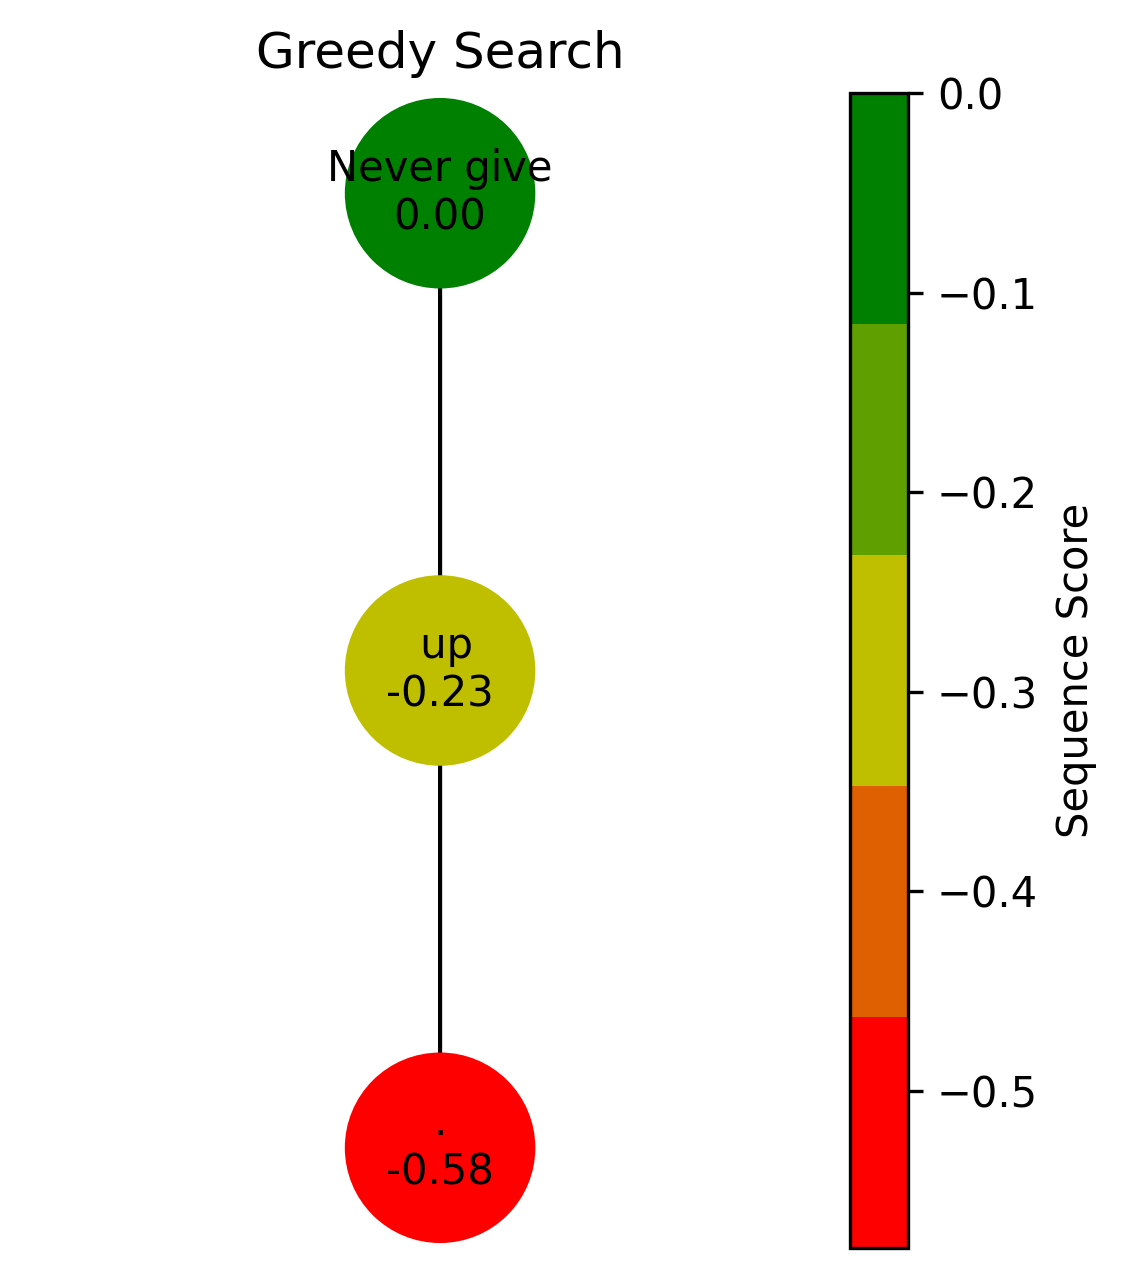

In [151]:
text = "Never give"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)
num_tokens_to_generate = 2
beam_width = 2

# Run Greedy Search
graph_greedy = nx.balanced_tree(1, num_tokens_to_generate, create_using=nx.DiGraph())
for node in graph_greedy.nodes:
    graph_greedy.nodes[node].update({
        'sequencescore': 0,
        'token': text
    })

graph = graph_greedy
greedy_output = greedy_search(input_ids, 0, num_tokens_to_generate)
plot_search_tree(graph_greedy, num_tokens_to_generate, 1, "Greedy Search")

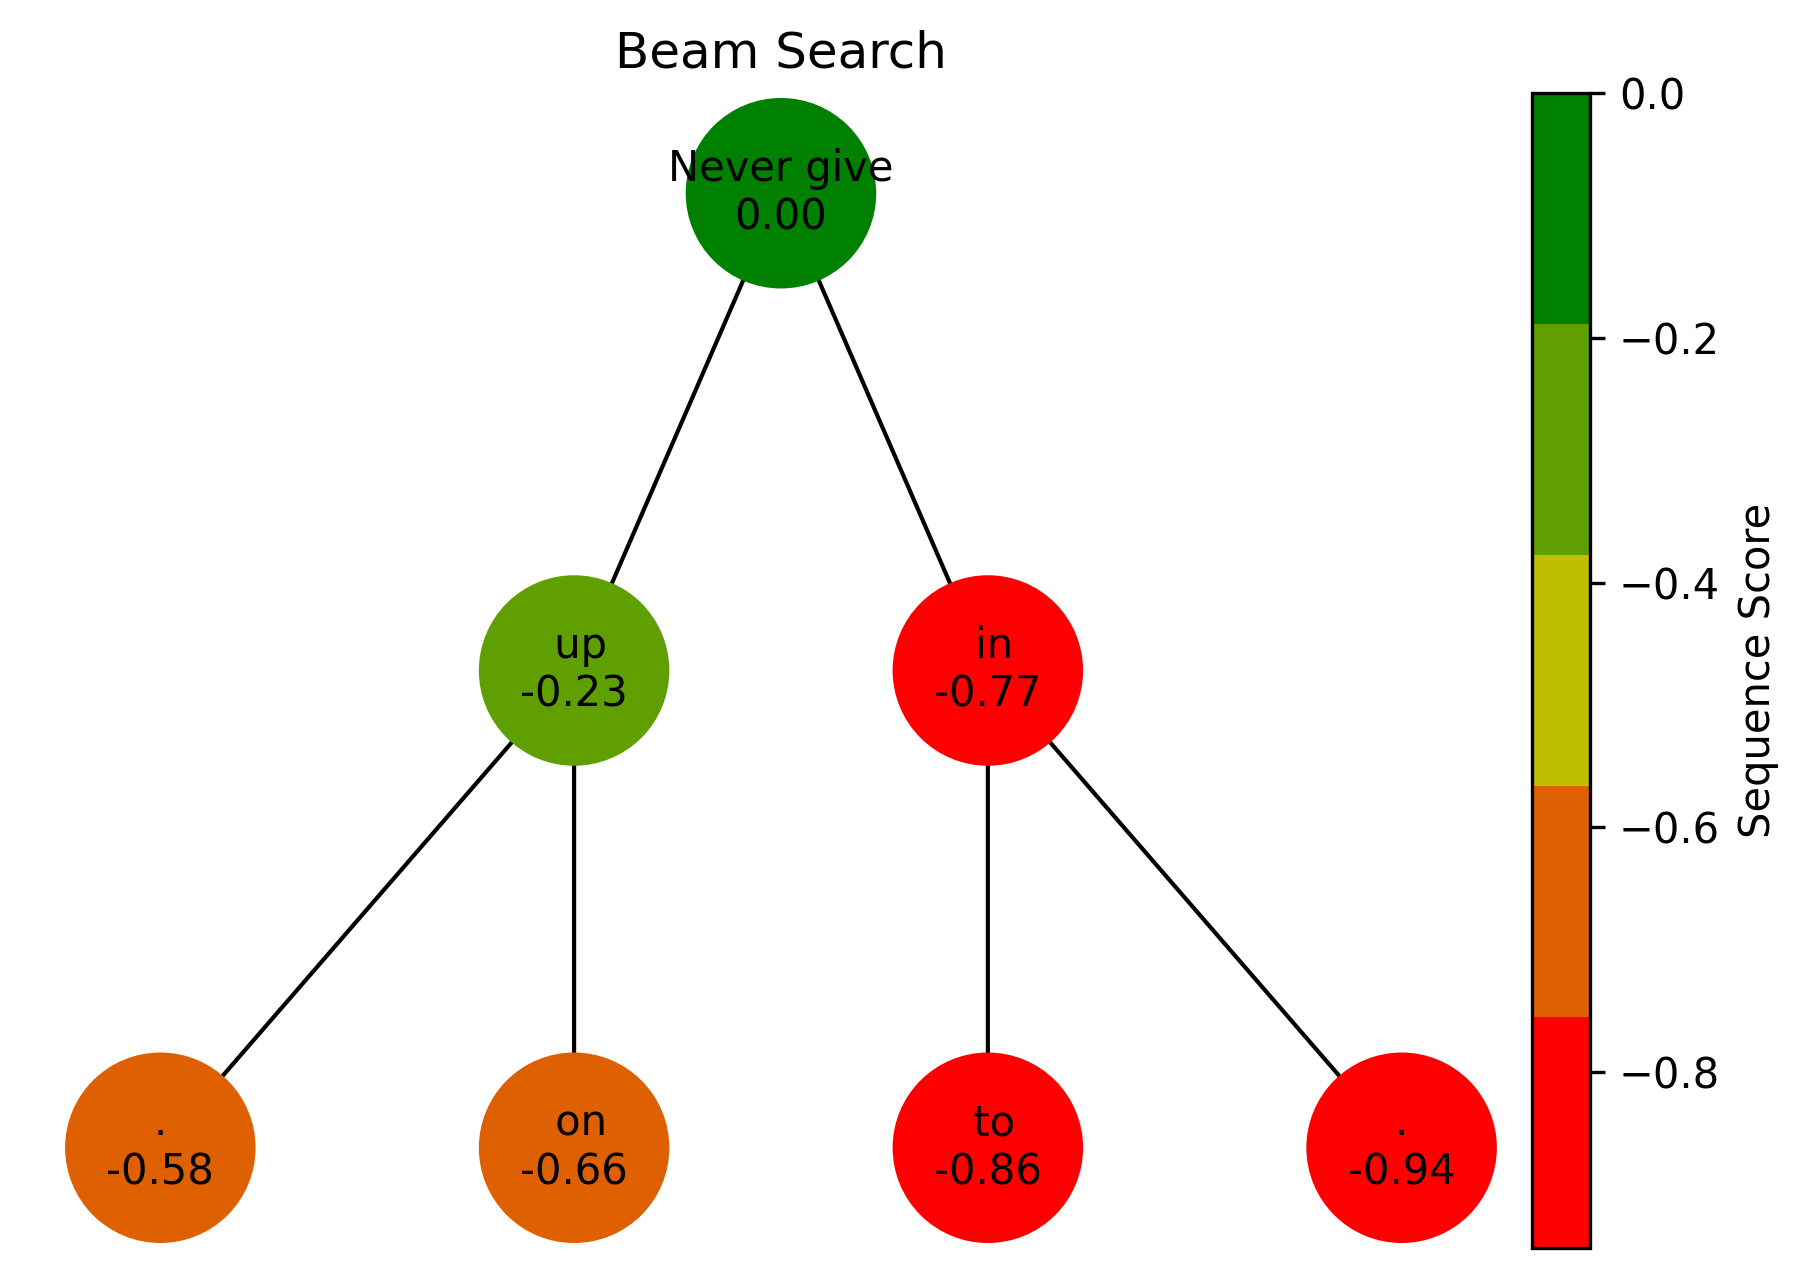

Greedy search output: Never give up.
Beam search output: Never give up.


In [152]:
# Run Beam Search
graph_beam = nx.balanced_tree(beam_width, num_tokens_to_generate, create_using=nx.DiGraph())
for node in graph_beam.nodes:
    graph_beam.nodes[node].update({
        'sequencescore': 0,
        'token': text
    })

graph = graph_beam
beam_search(input_ids, 0, num_tokens_to_generate, beam_width)
plot_search_tree(graph_beam, num_tokens_to_generate, beam_width, "Beam Search")

print("Greedy search output:", get_sequence(graph_greedy))
print("Beam search output:", get_sequence(graph_beam))